In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms

Tranformations

In [2]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,),std=(0.3081,))
                                       ])
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,),std=(0.3081,))
])

Data creation and train and test split

In [3]:
train = datasets.MNIST(root = "./data",train=True,transform=train_transforms,download=True)
test = datasets.MNIST(root="./data",train=False,transform=test_transforms,download=True)

DataLoaders

In [4]:
seed = 1
cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if cuda:
  torch.cuda.manual_seed(seed)
dataloader_args=dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True,batch_size =64)
train_loader = torch.utils.data.DataLoader(dataset=train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(dataset=test,**dataloader_args)

Sample image display

torch.Size([128, 1, 28, 28]) torch.Size([128])


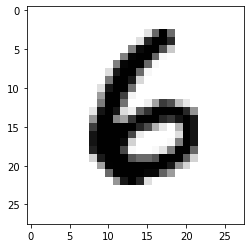

In [5]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
print(images.shape,labels.shape)


import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X=images[0].numpy().squeeze(),cmap='gray_r')
plt.show()

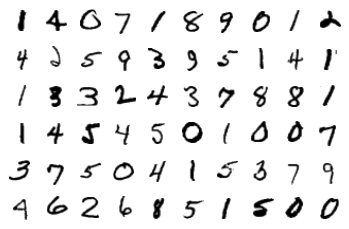

In [6]:
figure = plt.figure()
for i in range(1,60+1):
  plt.subplot(6,10,i)
  plt.axis('off')
  plt.imshow(X=images[i].numpy().squeeze(),cmap='gray_r')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False)

        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0, bias=False)

        self.fc1 = nn.Linear(128*8*8,120)
        self.fc2 = nn.Linear(120,10)

    def forward(self,x):

      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))

      x = self.pool(x)

      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))

      x = self.fc1(x.view(-1,128*8*8))
      x = self.fc2(x)

      return F.log_softmax(x, dim =1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
            Conv2d-2           [-1, 32, 24, 24]           4,608
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4           [-1, 64, 10, 10]          18,432
            Conv2d-5            [-1, 128, 8, 8]          73,728
            Linear-6                  [-1, 120]         983,160
            Linear-7                   [-1, 10]           1,210
Total params: 1,081,282
Trainable params: 1,081,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.37
Params size (MB): 4.12
Estimated Total Size (MB): 4.50
----------------------------------------------------------------


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06580203026533127 Batch_id=468 Accuracy=89.60: 100%|██████████| 469/469 [00:12<00:00, 36.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9789/10000 (97.89%)

EPOCH: 1


Loss=0.026055360212922096 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.026110293343663216 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.043218132108449936 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.026543011888861656 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.050102800130844116 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.04358188807964325 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.0031502379570156336 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.003906277008354664 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.006925256457179785 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.0012350265169516206 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.0019986701663583517 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9903/10000 (99.03%)

EPOCH: 12


Loss=0.0011061643017455935 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9918/10000 (99.18%)

EPOCH: 13


Loss=0.0003896342823281884 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.0001747576316120103 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:13<00:00, 35.64it/s]



Test set: Average loss: 0.0376, Accuracy: 9904/10000 (99.04%)



Text(0.5, 1.0, 'Test Accuracy')

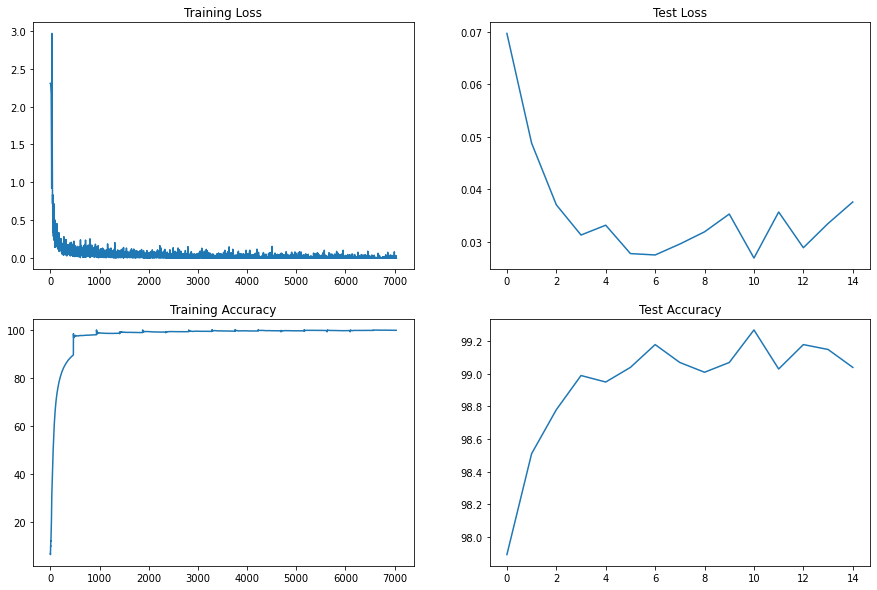

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")